In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
sns.set()

plt.rc('font', size=30)
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize=30)
plt.rc('figure', titlesize=30)

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.covariance import MinCovDet
import cvxpy as cvx

In [2]:
import pandas as pd
import numpy as np

import yfinance as yf
from tqdm import tqdm

from warnings import filterwarnings
filterwarnings('ignore')

Функции, реализованные ранее

In [3]:
def decrease_risk(mu, Sigma, R=2e-3):
    p = len(mu)
    w = cvx.Variable(p)
    obj = cvx.Minimize(1/2 * cvx.quad_form(w, Sigma))
    
    equal_constraints_1 = [mu.T @ w == R]
    equal_constraints_2 = [np.ones(p) @ w == 1]
    eyes = np.eye(p)
    nonequal_constraints = [eye @ w >= 0 for eye in eyes]
    constraints = equal_constraints_1 + equal_constraints_2 + nonequal_constraints
    
    problem = cvx.Problem(obj, constraints=constraints)
    result = problem.solve(verbose=False, solver="SCS")
    
    opt_weights = w.value
    return opt_weights

def count_portfolio_return(colums, weights, test):
    portfolio_return = 0
    for w, col in zip(weights, columns):
        one_company_return = w * (test[col] + 1).cumprod()
        portfolio_return += one_company_return
    return portfolio_return

def return_weights(df, R=2e-3):
    mean = df[df.columns].mean()
    df_sorted = df[mean.sort_values(ascending=False).index]
    
    mu = mean.sort_values(ascending=False).to_numpy()
    Sigma = df_sorted[df_sorted.columns].cov()
    
    w = decrease_risk(mu, Sigma, R)
    return w

def get_mu(df):
    num_of_companies = 15
    mean = df[df.columns].mean()
    top_returns = df[mean.sort_values(ascending=False).index]
    top_returns = top_returns.drop(top_returns.index[0])
    
    mu = mean.sort_values(ascending=False).to_numpy()
    return mu

def get_Sigma(df):
    Sigma = df[df.columns].cov()
    return Sigma

Следующим способом устанавливаем nsprcomp, для использования npca

In [4]:
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('NMF', 'nsprcomp', 'BiocManager')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))
    
nsprcomp = importr('nsprcomp')

# Allow conversion
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [5]:
data = pd.read_csv('sp500-0317.csv')
test = data.dropna(axis=1).set_index('Date')
test

,CDNS,SBAC,DRE,MGM,PKG,RMD,ANSS,RE,IT,DXC,...,VLO,VNO,WM,WAT,WY,WHR,XEL,XRX,XL,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-02,11.660000,0.460000,11.131988,16.932493,11.184379,6.975630,5.062500,43.199841,9.400000,8.209270,...,6.570942,14.562235,15.129817,22.020000,11.924259,37.775433,6.074376,17.462282,53.263206,33.542156
2003-01-03,9.240000,0.420000,11.326909,16.676165,11.405125,6.946424,5.000000,43.192123,9.350000,8.068741,...,6.476137,14.796793,15.245060,21.680000,11.856510,37.092781,6.176063,17.719086,53.575237,33.236809
2003-01-06,9.800000,0.480000,11.521826,16.138859,11.460310,7.045274,5.042500,43.400410,9.380000,8.295929,...,6.467518,14.992258,15.213055,21.920000,12.171902,38.256065,6.556044,18.061478,55.082233,34.161186
2003-01-07,9.360000,0.570000,11.283589,16.079704,11.558415,7.045274,5.350000,43.338703,9.300000,8.431775,...,6.388227,14.659962,15.104204,21.290001,12.146206,37.629150,6.315211,17.783279,54.776875,34.326260
2003-01-08,9.650000,0.630000,11.157979,13.950205,11.435781,7.067739,5.415000,42.659836,9.200000,8.256112,...,6.122767,14.386308,15.155424,20.910000,11.896222,37.698792,6.743364,17.697674,54.086426,34.689415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,42.259998,160.220001,26.860001,33.340000,120.089996,85.110001,146.660004,218.949997,123.589996,95.889999,...,91.129997,76.526649,85.910004,193.789993,34.939999,171.679993,47.886841,29.329153,35.169998,51.330002
2017-12-26,41.970001,159.820007,26.920000,33.349998,120.099998,85.589996,146.389999,219.729996,123.089996,95.900002,...,91.860001,76.893425,85.879997,193.820007,35.060001,170.160004,47.470001,29.160593,35.240002,50.860001
2017-12-27,42.250000,161.259995,27.120001,33.709999,120.540001,85.760002,146.660004,219.979996,123.970001,94.730003,...,92.139999,77.081772,86.110001,193.449997,35.099998,170.080002,47.799999,29.230000,35.200001,50.709999


In [6]:
prices = test

In [15]:
returns = prices.apply(lambda x: x.pct_change(1).fillna(0), axis=0)
returns = returns.drop(returns.index[0])
train_size = 2500
returns_train = returns[:train_size]
returns_test = returns[train_size:]

In [36]:
def make_dim_red(df, ncomp = 2, window_size = 10):
    time_size = len(df.index)
    
    new_prices = list()

    for i in range(0, time_size, window_size):
        var = nsprcomp.nsprcomp(df[i : i + window_size].T, ncomp=ncomp, center = False, scale = False, nneg = True)
        new_prices.append(SVP(var[6].T))
    
    new_prices = np.vstack(new_prices)
    df_new_prices = pd.DataFrame(data=new_prices, index=np.arange(0, len(new_prices)), columns=df.columns)
    new_returns = df_new_prices.apply(lambda x: x.pct_change(1).fillna(0), axis=0)
    new_returns = new_returns.drop(new_returns.index[0])
    
    return new_returns

def SVP(components):
    r = len(components)
    s = np.zeros(r)
    
    for i in range(r):
        s[i] = sum((components[i] - np.mean(components))**2) / (len(components[0]) - 1)
    
    c = np.zeros(r)
    
    for i in range(r):
        c[i] = s[i] / sum(s)
        
    ans = components.T @ c
    return ans

In [23]:
new_returns = make_dim_red(prices[:train_size], 1, 3)

In [24]:
var

sdev,[RTYPES.REALSXP]
rotation,[RTYPES.REALSXP]
center,[RTYPES.LGLSXP]
scale,[RTYPES.LGLSXP]
xp,[RTYPES.REALSXP]
q,[RTYPES.REALSXP]
x,[RTYPES.REALSXP]


In [25]:
new_returns

,CDNS,SBAC,DRE,MGM,PKG,RMD,ANSS,RE,IT,DXC,...,VLO,VNO,WM,WAT,WY,WHR,XEL,XRX,XL,ZION
1,-0.050247,0.314991,-0.012796,-0.106632,0.015661,0.015559,0.084295,-0.006230,-0.003361,0.018311,...,-0.026879,-0.020395,-0.002643,-0.036732,0.002886,0.007014,0.047333,0.003133,0.014288,0.033573
2,0.039916,0.022934,-0.019457,-0.036500,0.012397,0.037306,0.017643,-0.028811,0.004123,0.006403,...,0.037062,-0.019581,0.011593,0.002456,0.034970,0.031435,0.001159,0.054171,0.006566,0.017125
3,-0.015145,0.021785,-0.019676,-0.039424,-0.010629,0.029532,-0.028009,-0.032679,-0.004936,-0.067030,...,-0.009433,-0.021178,-0.006506,0.007423,-0.007771,0.003646,-0.011664,0.026295,-0.019193,-0.013807
4,0.001566,-0.128636,-0.004983,-0.040337,-0.041468,-0.011844,-0.062263,-0.037082,-0.046028,-0.037989,...,-0.046168,-0.020984,0.001459,-0.024116,-0.024308,-0.042809,-0.012523,-0.036877,-0.018944,0.001489
5,0.016172,-0.018444,-0.006211,-0.014931,-0.044982,-0.002728,-0.041528,-0.000378,-0.041156,-0.020402,...,-0.051395,-0.010734,-0.038134,0.005400,-0.044116,-0.045925,-0.047248,-0.009681,-0.035384,-0.018068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,0.012890,0.012533,0.007888,0.026960,0.026684,0.028799,-0.002568,0.007885,0.003883,0.027381,...,0.031244,-0.001912,0.013645,0.012127,0.013008,0.033853,-0.001575,0.004249,0.015840,0.018561
830,0.029650,0.010924,0.022786,0.028448,0.031286,0.008758,-0.006437,0.012551,0.029681,0.048836,...,0.051820,0.015980,0.021039,0.007340,0.025049,0.032263,-0.000703,0.032991,0.013114,0.038456
831,-0.004893,0.005286,-0.000796,0.005404,-0.000576,0.020779,-0.016277,0.020819,0.003582,0.014841,...,0.005647,0.001589,0.010857,0.008801,0.006261,0.001842,0.015812,0.014777,-0.004946,-0.021635
832,-0.012164,0.012003,0.004263,0.012732,-0.008278,-0.007744,0.002191,0.007522,-0.005518,0.013957,...,0.013805,0.014267,0.009044,0.007490,0.026871,-0.006853,0.012935,0.029379,0.009388,-0.012440


In [26]:
npca_w = return_weights(new_returns)

In [27]:
columns = returns_test.columns.to_numpy()
npca_portfolio_return = count_portfolio_return(columns, npca_w, returns_test)
npca_portfolio_return

Date
2012-12-07    1.001858
2012-12-10    1.004796
2012-12-11    1.011626
2012-12-12    1.017142
2012-12-13    1.015536
                ...   
2017-12-22    3.406941
2017-12-26    3.390753
2017-12-27    3.387283
2017-12-28    3.425458
12/29/2017    3.407438
Name: CDNS, Length: 1275, dtype: float64

In [22]:
n_comp = 1
pca = PCA(n_components=n_comp) 
pca.fit(returns_train.cov())
pca_Sigma = pca.get_covariance()
pca_Sigma
mu = get_mu(returns_train)
mu[:5], mu.shape
pca_w = decrease_risk(mu, pca_Sigma)
pca_w, np.sum(pca_w)
columns = returns_train.columns.to_numpy()
pca_portfolio_return = count_portfolio_return(columns, pca_w, returns_test)
pca_portfolio_return

Date
2012-12-07    1.005860
2012-12-10    1.009574
2012-12-11    1.013145
2012-12-12    1.015658
2012-12-13    1.008153
                ...   
2017-12-22    2.657209
2017-12-26    2.651319
2017-12-27    2.664272
2017-12-28    2.675967
12/29/2017    2.657975
Name: CDNS, Length: 1275, dtype: float64

Функция для оптимизации количества компонентов и размера окна

In [72]:
def calc_ratio(returns):
    return np.mean(returns) / np.std(returns)

def get_best_params(prices_df, test_df, comp_grid, window_grid):
    best_ratio = -1
    best_params = [0, 0]

    for n_comp in comp_grid:
        for window_size in window_grid:
            if n_comp > window_size:
                continue
            try:
                returns = make_dim_red(prices_df, n_comp, window_size)
                npca_w = return_weights(returns)
                
                npca_portfolio_return = count_portfolio_return(test_df.columns, npca_w, test_df)
                cur_ratio = calc_ratio(npca_portfolio_return)
                if cur_ratio > best_ratio:
                    best_ratio = cur_ratio
                    best_params[0] = n_comp
                    best_params[1] = window_size
            except Exception:
                continue
            print(n_comp, window_size, cur_ratio)
            print('-----------------')
    return best_params

In [30]:
a = np.array(pca_portfolio_return)

In [31]:
calc_ratio(a)

4.00836719358176

In [32]:
b = np.array(npca_portfolio_return)

In [33]:
calc_ratio(b)

3.4635852404540786

In [73]:
%%time
best_comp, best_w_size = get_best_params(prices[:train_size], returns_test, range(1, 5), range(3, 10))

1 3 3.463585232246889 [1, 3]
-----------------
1 4 5.160031442529401 [1, 4]
-----------------
1 5 6.740394649840303 [1, 5]
-----------------
1 7 4.479205941742169 [1, 5]
-----------------
1 8 5.151874646222583 [1, 5]
-----------------
1 9 4.993933712155837 [1, 5]
-----------------
2 3 3.6185143035740635 [1, 5]
-----------------
2 4 4.91591066545561 [1, 5]
-----------------
2 5 5.255371321173989 [1, 5]
-----------------
2 7 5.227985630186423 [1, 5]
-----------------
2 8 7.441139308343228 [2, 8]
-----------------
2 9 6.116391369030476 [2, 8]
-----------------
3 3 3.4740416457361194 [2, 8]
-----------------
3 4 5.09550973458379 [2, 8]
-----------------
3 5 6.808827664371097 [2, 8]
-----------------
3 7 6.324611961439897 [2, 8]
-----------------
3 8 7.570440082555051 [3, 8]
-----------------
3 9 5.798124359230753 [3, 8]
-----------------
4 4 6.278547698500102 [3, 8]
-----------------
4 5 5.517851743624101 [3, 8]
-----------------
4 7 6.0015456894966395 [3, 8]
-----------------
4 8 6.053889

In [75]:
best_comp, best_w_size

(3, 8)

In [80]:
returns = make_dim_red(prices[:train_size], best_comp, best_w_size)
npca_w = return_weights(returns)

npca_portfolio_return = count_portfolio_return(returns_test.columns, npca_w, returns_test)
cur_ratio = calc_ratio(npca_portfolio_return)
cur_ratio

7.673302505243777

In [76]:
npca_portfolio_return

Date
2012-12-07    1.006153
2012-12-10    1.006301
2012-12-11    1.009966
2012-12-12    1.009817
2012-12-13    1.005261
                ...   
2017-12-22    2.009267
2017-12-26    2.010445
2017-12-27    2.013712
2017-12-28    2.017348
12/29/2017    2.012193
Name: CDNS, Length: 1275, dtype: float64

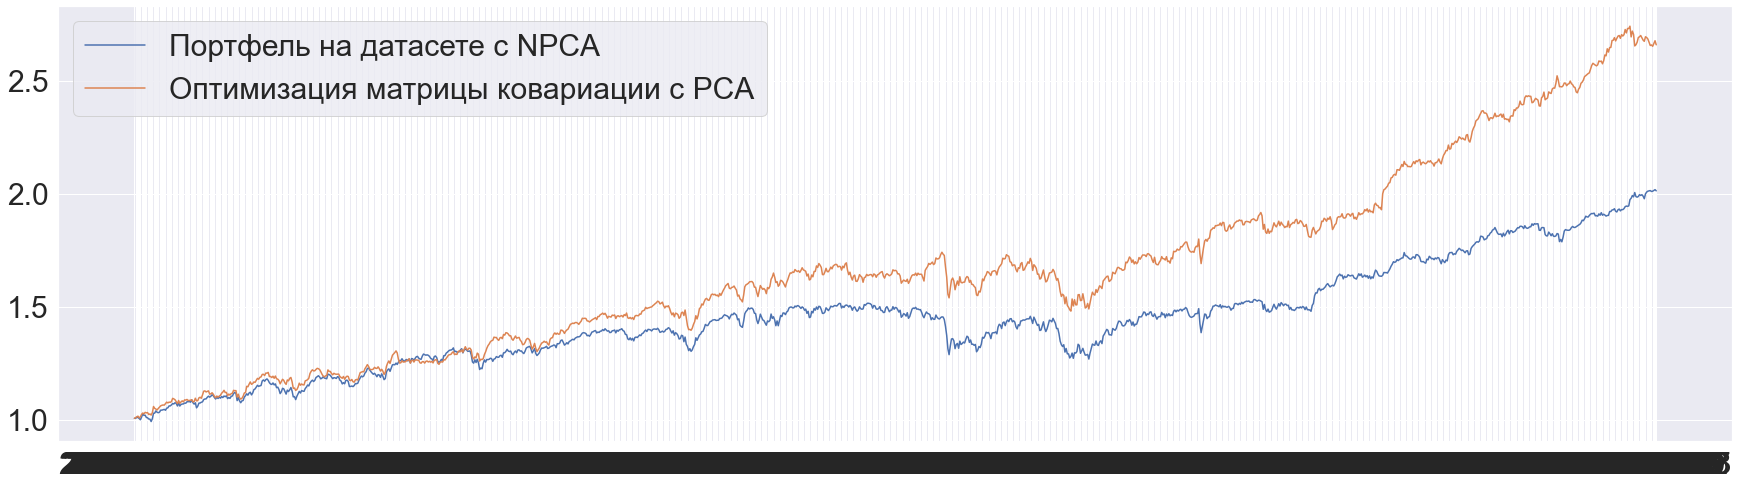

In [77]:
plt.figure(figsize=(30, 8))

plt.plot(returns_test.index, npca_portfolio_return, label='Портфель на датасете с NPCA')
plt.plot(returns_test.index, pca_portfolio_return, label='Оптимизация матрицы ковариации с PCA')
plt.legend()

plt.show()